# Data Mining Project Code

Title: Effect of pandemics on stock prices

Team members: Aitore Issadykova, Assem Kussainova

In [45]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import seaborn
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

In [46]:
def read_data(stock):
    sars = web.DataReader(stock, data_source = 'yahoo', start = "2003-03-01", end = "2003-06-01")
    mers = web.DataReader(stock, data_source = 'yahoo', start = "2014-01-01", end = "2014-04-01")    
    ebola = web.DataReader(stock, data_source = 'yahoo', start = "2015-09-01", end = "2015-12-01")
    return sars, mers, ebola

In [193]:
sars, mers, ebola = read_data("AMZN")

# Visualization of data

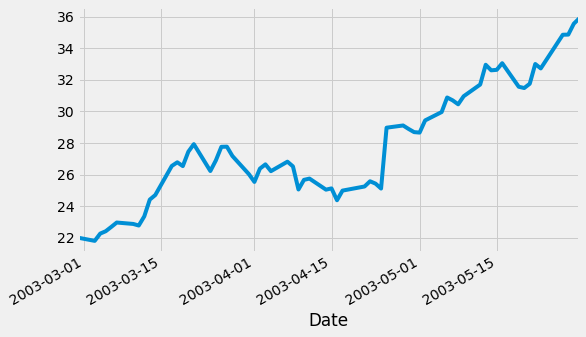

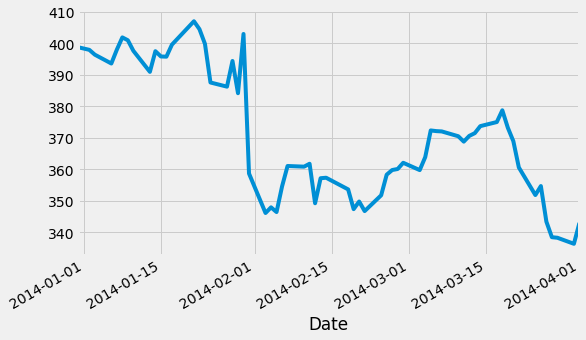

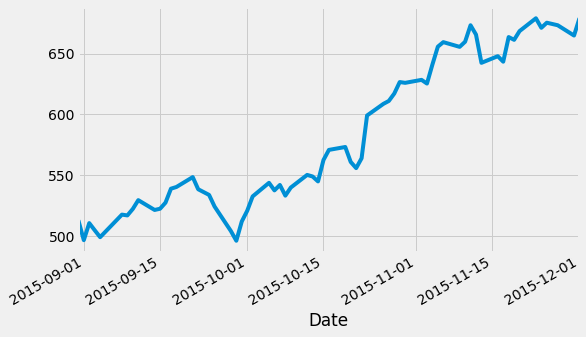

In [194]:
sars['Close'].plot(figsize=(8, 5))
plt.show()
mers['Close'].plot(figsize=(8, 5))
plt.show()
ebola['Close'].plot(figsize=(8, 5))
plt.show()

# Build and Test Model

# ARIMA

In [195]:
train, test = mers["Close"], ebola["Close"]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

pred = predictions
mn = pred.index(min(pred))
mx = pred.index(max(pred[mn:]))
ror = (test[mx]-test[mn])/test[mn]
pm=(test[mx]-test[mn])/test[mx]*100

rmse = sqrt(mean_squared_error(test, pred))
mape= np.mean(np.abs((np.asarray(test) - np.asarray(pred)) / np.asarray(test))) * 100
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test ROR: %.3f' % ror)
print('Test PM: %.3f' % pm)

Test RMSE: 24.518
Test MAPE: 12.345
Test ROR: 0.309
Test PM: 23.580


In [163]:
mape = mean_absolute_percentage_error(test, pred)
mape

4.91599527222029

# Linear Regression

In [196]:
sarsClose = sars[['Close']]
mersClose = mers[['Close']]
ebolaClose = ebola[['Close']]

In [197]:
forecast_out = 1
mersClose['Prediction'] = mersClose[['Close']].shift(-1)
ebolaClose['Prediction'] = ebolaClose[['Close']].shift(-1)

In [198]:
X_train = np.array(mersClose.drop(['Prediction'], 1))
X_train = X_train[:-forecast_out]

In [199]:
y_train = np.array(mersClose['Prediction'])
y_train = y_train[:-forecast_out]

In [200]:
X_test = np.array(ebolaClose.drop(['Prediction'], 1))
X_test = X_test[:-forecast_out]

y_test = np.array(ebolaClose['Prediction'])
y_test = y_test[:-forecast_out]

In [201]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_confidence = lr.score(X_test, y_test)
print("lr confidence:", lr_confidence)
y_pred = lr.predict(X_test)

lr confidence: 0.8648156861764509


In [202]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

3.351851378164889

In [203]:
y_pred = list(y_pred)
mn=y_pred.index(min(y_pred))
mx=y_pred.index(max(y_pred[mn:]))
ror = (y_test[mx]-y_test[mn])/y_test[mn]
pm=(y_test[mx]-y_test[mn])/y_test[mx]*100

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test ROR: %.3f' % ror)
print('Test PM: %.3f' % pm)

Test RMSE: 22.487
Test MAPE: 3.352
Test ROR: 0.311
Test PM: 23.729


# SVM

In [204]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel = 'linear', C = 1e3, gamma = 0.1)
svr_rbf.fit(X_train, y_train)
svm_confidence = svr_rbf.score(X_test, y_test)
print("svm confidence:", svm_confidence)

svm confidence: 0.892763447405777


In [205]:
y_pred = svr_rbf.predict(X_test)

In [206]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

2.8771284373085413

In [207]:
y_pred = list(y_pred)
mn=y_pred.index(min(y_pred))
mx=y_pred.index(max(y_pred[mn:]))
ror = (y_test[mx]-y_test[mn])/y_test[mn]
pm=(y_test[mx]-y_test[mn])/y_test[mx]*100

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test ROR: %.3f' % ror)
print('Test PM: %.3f' % pm)

Test RMSE: 20.028
Test MAPE: 2.877
Test ROR: 0.311
Test PM: 23.729


# LSTM

In [65]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use("fivethirtyeight")

In [176]:
mersData = mers.filter(['Close'])
dataset = mersData.values

In [177]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

In [178]:
train_data = scaled_data[:, :]
x_train = []
y_train = []

for i in range(1, len(train_data)):
    x_train.append(train_data[i-1:i, 0])
    y_train.append(train_data[i, 0])

In [179]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [180]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(62, 1, 1)

In [181]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [182]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [183]:
model.fit(x_train, y_train, batch_size = 1, epochs = 10)

Epoch 1/10
62/62 [==============================] - 4s 60ms/step - loss: 0.1026
Epoch 2/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0278
Epoch 3/10
62/62 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 4/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 5/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 6/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 7/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 8/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 9/10
62/62 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 10/10
62/62 [==============================] - 0s 4ms/step - loss: 0.0098


In [184]:
ebolaData = ebola.filter(['Close'])
dataset = ebolaData.values

In [185]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

In [186]:
test_data = scaled_data[:, :]
x_test = []
y_test = []

for i in range(1, len(test_data)):
    x_test.append(test_data[i-1:i, 0])
    y_test.append(test_data[i, 0])

In [187]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [188]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(64, 1, 1)

In [189]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [115]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [192]:
mape = mean_absolute_percentage_error(y_t, predictions)
mape

1.4290802145160701

In [190]:
y_pred = list(y_pred)
mn=y_pred.index(min(y_pred))
mx=y_pred.index(max(y_pred[mn:]))
ror = (y_test[mx]-y_test[mn])/y_test[mn]
pm=(y_test[mx]-y_test[mn])/y_test[mx]*100

rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test ROR: %.3f' % ror)
print('Test PM: %.3f' % pm)

Test RMSE: 140.171
Test MAPE: 1.990
Test ROR: 3.862
Test PM: 79.433


In [191]:
y_t = scaler.inverse_transform(y_test.reshape(-1, 1))

In [118]:
y_t

array([[21800.],
       [22440.],
       [22580.],
       [22240.],
       [22620.],
       [22940.],
       [22680.],
       [22300.],
       [22480.],
       [22460.],
       [23040.],
       [23140.],
       [23800.],
       [23000.],
       [22900.],
       [22620.],
       [22520.],
       [22240.],
       [22680.],
       [22680.],
       [22380.],
       [22300.],
       [23020.],
       [25020.],
       [25400.],
       [25200.],
       [25040.],
       [25080.],
       [25380.],
       [25300.],
       [25120.],
       [25320.],
       [25400.],
       [25600.],
       [25780.],
       [25840.],
       [25960.],
       [26160.],
       [26500.],
       [27440.],
       [27660.],
       [27040.],
       [26600.],
       [26840.],
       [26760.],
       [26880.],
       [26420.],
       [26660.],
       [26340.],
       [26000.],
       [25260.],
       [25400.],
       [25620.],
       [25780.],
       [25700.],
       [25640.],
       [25980.],
       [25980.],
       [26700.